In [1]:
import sys

sys.path.append('/home/daniel/ml_workspace/circuit-finder')

In [2]:
# Find the residual null space
import torch 
from circuit_finder.pretrained import load_model 

model = load_model()

W_U = model.W_U
U, S, V = torch.svd(W_U)
U_null = U[:, -12:]

/home/daniel/ml_workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [3]:
print(model)

HookedSAETransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
     

In [4]:
from datasets import load_dataset

dataset = load_dataset("c4", "en", streaming=True)

/home/daniel/ml_workspace/circuit-finder/.venv/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for c4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/c4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/daniel/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


In [5]:
from circuit_finder.utils import clear_memory
from tqdm import tqdm
import torch

cluster_mean_1 = torch.load('cluster_1_mean.pt')
cluster_mean_2 = torch.load('cluster_2_mean.pt')

resid_act_dots_cluster_mean_1 = []
resid_act_dots_cluster_mean_2 = []
resid_act_null_norms = []

n_tokens = 0
with torch.no_grad():
    for element in tqdm(dataset['train'].take(2)):
        text = element['text']
        _, cache = model.run_with_cache(text, names_filter = "blocks.11.hook_resid_post")
        # Do stuff with cache
        resid_act = cache['blocks.11.hook_resid_post']
        n_tokens += resid_act.shape[1]
        # Compute the component of the residual in the null space
        resid_act_null = resid_act @ U_null
        resid_act_null_norm = torch.norm(resid_act_null, dim=-1).squeeze(0)
        resid_act_null_norms.extend(resid_act_null_norm.tolist())
        # Compute the dot product with the cluster mean
        resid_act_dot = (resid_act @ cluster_mean_1).squeeze(0)
        resid_act_dots_cluster_mean_1.extend(resid_act_dot.tolist())
        resid_act_dot = (resid_act @ cluster_mean_2).squeeze(0)
        resid_act_dots_cluster_mean_2.extend(resid_act_dot.tolist())

        del cache
        del resid_act
        del resid_act_null
        del resid_act_dot
        clear_memory()

print(n_tokens)

200it [00:30,  6.58it/s]

74737


Text(0.5, 1.0, 'Residual stream dot product with SAE entropy feature cluster means')

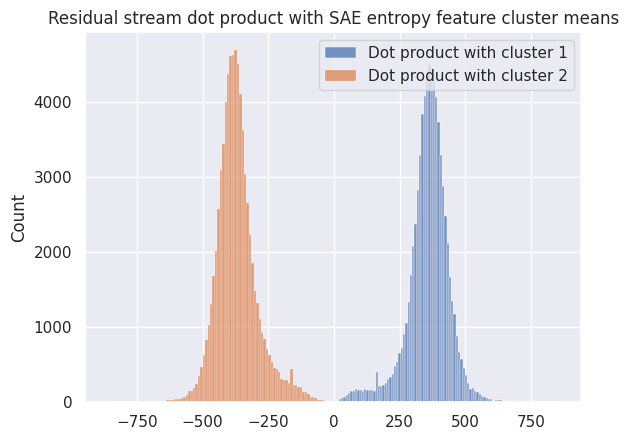

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set_theme()
fig, ax = plt.subplots()
sns.histplot(resid_act_dots_cluster_mean_1, bins=100, label = "Dot product with cluster 1", ax = ax )
sns.histplot(resid_act_dots_cluster_mean_2, bins=100, label = "Dot product with cluster 2", ax = ax )
ax.legend()
plt.title("Residual stream dot product with SAE entropy feature cluster means")